## Decision Trees

In this latest 'build your own ML model' I am going to tackle decision trees. Like always with these blogs, the aim is not to build the most accurate and well tuned model, but to understand the process behind building the model, how the model makes predictions and how the tuning of the model works, furthermore what I've shown here is likely far from the most efficient and robust way of code the model, for example it would break with different data inputs and would be much more useable if built as a Class, but again this is not the goal. As a result, when using in built modelling packages and deploying models I have a fundamental understanding of what the models are doing.

Usually with these blogs I work through the coding first and then write the blog after, with a complete solution. However, in this case I thought it would be interesting to work through my thought process step by step, since I slowly built this model up by starting very basic and getting quite complex.

To create a decision tree we need to go through the process of recursive binary splitting, in which we choose to split the data into two 'nodes' each of which predict the class as the mode class of that node. To start I am going to do this on a simple binary classification problem with one predictor. 

To perform the recursive binary splitting we need to find the value of cutpoint 's' in the range of our predictor X that minimizes the Gini index:
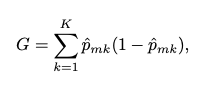
Where p_mk is the propotion off training observations in the mth region that are from the kth class. In the Introduction to Statistical Learning by Gareth James et al. (ISLP) it is not clear how to aggregate the Gini Index across the new nodes but subsequent Googling I have found we need to minimize the weighted average of the Gini Index of the two new nodes, weighted by the number of training observations, which intuitively makes sense. Let's start with the Iris dataset and select on class and one predictor:

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
df = load_iris(as_frame=True)
df.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [2]:
df.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Let's select our predictor as sepal length and class as versicolor (or not versicolor).

In [3]:
X = df.data["sepal length (cm)"]
y = (df.target == 1) * 1

We need to find a value s in the range of X which minimizes the Gini Index. Let's build a function that takes inputs s, X and y that produces a Gini Index to be minimized for a single node and a weighting for that node, let's say less than s.

In [4]:
def G_left(s, X, y):
    y_1 = y[X <= s]
    p_11 = sum(y_1 == 1)/len(y_1)
    p_12 = sum(y_1 == 0)/len(y_1)
    return (p_11*(1-p_11) + p_12*(1-p_12), len(y_1)/len(y))

Now let's do the same for greater than s and then combine them into a function to produce the weighted average.

In [5]:
def G_right(s, X, y):
    y_2 = y[X > s]
    p_21 = sum(y_2 == 1)/len(y_2)
    p_22 = sum(y_2 == 0)/len(y_2)
    return (p_21*(1-p_21) + p_22*(1-p_22), len(y_2)/len(y))

def G(s, X, y):
    return G_left(s, X, y)[0] * G_left(s, X, y)[1] + G_right(s, X, y)[0] * G_right(s, X, y)[1]

To find s that minimizes G, let's run through all possible values of s that might split the training data. By doing this to two decimal places, we know we can cover every possible split of the data.

In [6]:
S = pd.DataFrame(np.arange(X.min(), X.max()-0.1, 0.01), columns=["s"])

Then apply G to each possible s, and plot to find a minimum.

In [7]:
S["G"] = S["s"].apply(G, args=(X,y))

<Axes: xlabel='s', ylabel='G'>

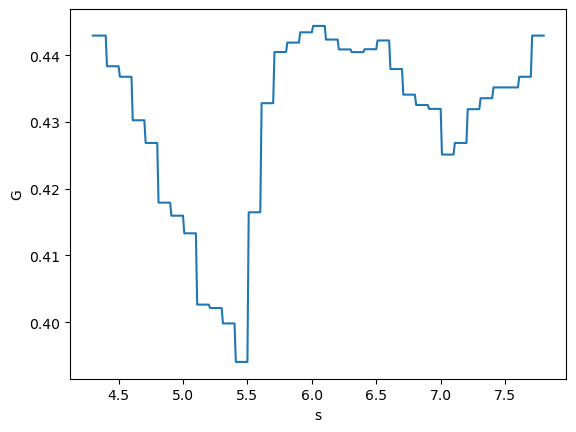

In [8]:
import seaborn as sns
sns.lineplot(data=S, x="s", y="G")

In [9]:
s = round(S[S["G"] == S["G"].min()]["s"].median(),2)
s

5.45

Therefore s = 5.45 for our first split (I'm taking the median here to get a sensible split but any minimum would give us the same result). Let's test our first split by building a tree of depth 1 using SKLearn.

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(max_depth=1)

In [11]:
clf.fit(np.array(X).reshape(-1,1),y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'x[0] <= 5.45\ngini = 0.444\nsamples = 150\nvalue = [100, 50]'),
 Text(0.25, 0.25, 'gini = 0.204\nsamples = 52\nvalue = [46, 6]'),
 Text(0.75, 0.25, 'gini = 0.495\nsamples = 98\nvalue = [54, 44]')]

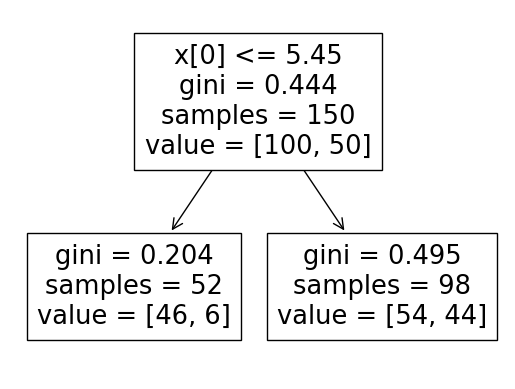

In [12]:
plot_tree(clf)

Here we see our split matches the split scikit learn gives us and below we show our resulting Gini Indices match too.

In [13]:
G_left(5.45, X, y)[0], G_right(5.45, X, y)[0]

(0.20414201183431957, 0.49479383590170756)

The next challenge is to do this recursively until some kind of stopping criteria, while storing the results. A common stopping criteria (or pre-pruning method) is to split nodes if they have some minimum number of training data points and probably easier to code than max-depth right now. 

My idea is to create an object that contains the nodes of the training dataset as we split it up, until these nodes come to represent the leaf nodes, call this the node_set. This will start out just being the whole training data and target as a tuple. I will want to record the size of each node (node_set_count) as well the split value s for each node that is split (node_split). I define the starter values for each of these objects below.

In [14]:
node_set = [(X,y)]
node_set_count = [len(node[0]) for node in node_set]
node_split = []

For this to work I need to be able to select the nodes in the node set that still have more observations than the minimum split. To do this I have defined a function that will order the node set by the number of observations in each node.

In [15]:
def sort_by_size(node_set_count, node_set):
    list_order = index_list = np.array(node_set_count).argsort().tolist()[::-1]
    return [node_set[i] for i in list_order]

Finally, I will create the recursion that runs until all nodes have less than (arbitrarily) 20 observations  and selects the largest node and sets the training_node and target_node objects that we will perform the split on. Calculates s that minimizes the Gini Index for that node as before and splits the selected training and target variables by s and puts them back into the node set. We record s in the node_split and recalculate the count of samples in each node to sort them in the next recursion. We end up with the leaf nodes in the node_set and each split s in the node_split.

In [16]:
while max(node_set_count) >= 20: # Where 20 is the minimum samples in a node to split
    
    #Order the node set so that the recursion selects the largest to split
    node_set = sort_by_size(node_set_count,node_set)
    
    # Select node to perform split on
    training_node = node_set[0][0]
    target_node = node_set[0][1]
    
    # Create all values of s that might produce a valid split
    S = pd.DataFrame(np.arange(training_node.min(), training_node.max()-0.01, 0.01), columns=["s"])
    
    # Calculate Gini Indices
    S["G"] = S["s"].apply(G, args=(training_node, target_node))
    
    # Find s that minimizes G
    s = round(S[S["G"] == S["G"].min()]["s"].median(),2)
    
    # Split the nodes training and target, remove the original node and add the new nodes to node_set
    X1 = training_node[training_node <= s]
    y1 = target_node[training_node <= s]
    X2 = training_node[training_node > s]
    y2 = target_node[training_node > s]
    node_set.remove((training_node,target_node))
    node_set.extend(((X1,y1),(X2,y2)))
    
    # Add split s and re-count the observations in each node set
    node_split.append(s)
    node_set_count = [len(i[0]) for i in node_set]

Let's have a look at the splits we have calculated.

In [17]:
node_split

[5.45, 6.25, 4.85, 7.05, 5.65, 6.95, 6.55, 5.05, 5.85, 6.45, 5.15]

Again, let's compare to the decision tree produced by sklearn:

In [18]:
clf2 = DecisionTreeClassifier(min_samples_split=20)
clf2.fit(np.array(X).reshape(-1,1),y)

DecisionTreeClassifier(min_samples_split=20)

In [19]:
threshold = clf2.tree_.threshold[clf2.tree_.threshold > 0].round(2)

In [20]:
threshold.sort()
node_split.sort()
threshold == node_split

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

We can see that our split values are the same. Since this is a decision tree with only one variable then our trees will be the same. I will go into predicting values later.

Now to introduce other variables and classes.

In [21]:
X1 = df.data["sepal length (cm)"]
X2 = df.data["sepal width (cm)"]
X3 = df.data["petal length (cm)"]
X4 = df.data["petal width (cm)"]
y = df.target

We must re-define our Gini Index functions to include the third class:

In [22]:
def G_left(s, X, y):
    y_1 = y[X <= s]
    p_11 = sum(y_1 == 1)/len(y_1)
    p_12 = sum(y_1 == 0)/len(y_1)
    p_13 = sum(y_1 == 2)/len(y_1)
    return (p_11*(1-p_11) + p_12*(1-p_12) + p_13*(1-p_13), len(y_1)/len(y))

def G_right(s, X, y):
    y_2 = y[X > s]
    p_21 = sum(y_2 == 1)/len(y_2)
    p_22 = sum(y_2 == 0)/len(y_2)
    p_23 = sum(y_2 == 2)/len(y_2)
    return (p_21*(1-p_21) + p_22*(1-p_22) + p_23*(1-p_23), len(y_2)/len(y))

def G(s, X, y):
    return G_left(s, X, y)[0] * G_left(s, X, y)[1] + G_right(s, X, y)[0] * G_right(s, X, y)[1]

When introducing the new variables I encountered some problems when recursively running through the node set, since I had nodes with many observations that were pure i.e. Gini Index of 0, but the algorithm was still trying to split. A better solution I found was to start with the same node set and move nodes to a new object called the node_set_final when they did not require extra splitting, i.e. they were pure or had below the minimum number of samples. This node set final comes to represent the leaf nodes of the final decision tree. The recursion then stops when the node set is empty.

Further modifications required in building the model with a number predictors are sorting through the Gini Indices of each predictor to find the minimum and selecting that predictor to split the node by. I have also recorded the predictor related to each split in the node_split object. Again, we have used the arbitrary minimum samples to split at 20.

In [23]:
# Define the node set, node split and the node set final
node_set = [pd.DataFrame(np.array([X1,X2,X3,X4,y]).transpose(), columns=["X1","X2","X3","X4","y"])]
node_split = []
node_set_final = []

#Create the recursion to perform as long as there is still a node in the node set
while len(node_set) > 0:
    
    # Select the first node in the node set to perform the split and remove it from the node set
    # Define the training and target sets
    node_select = node_set[0]
    node_set.remove(node_select)
    training_node = node_select[["X1","X2","X3","X4"]]
    target_node = node_select["y"]
    
    # Loop through the predictors creating all 100 possible values of s and calculate the Gini Index
    S = pd.DataFrame()
    for col in training_node.columns:
        S[col] = np.linspace(training_node[col].min(), training_node[col].max(), 100, endpoint=False)
        
        # Gini index for predictor with one value is 0, but cannot split so ignore
        if training_node[col].min() ==  training_node[col].max():
            pass
        else:
            S["G"+col] = S[col].apply(G, args=(training_node[col], target_node))
    
    # Select the column that contains the minimum Gini Index and calculate s
    col_to_split = S.drop(["X1","X2","X3","X4"], axis=1).min().idxmin()
    s = round(S[S[col_to_split] == S[col_to_split].min()][col_to_split[-2:]].median(),2)
    
    # Check in the minimum Gini = 0, if so do not split and add node the the node_set_final
    if S.drop(["X1","X2","X3","X4"], axis=1).sum(axis=1).min() == 0:
        node_set_final.append(node_select)
        
    # Else split the selected node by s to a right and left branch
    else:
        node_set_left = node_select[node_select[col_to_split[-2:]] >= s]
        node_set_right = node_select[node_select[col_to_split[-2:]] < s]
        
        # If the minimum samples requirement is not met then add to final, if not add back to be split again
        if len(node_set_left["X1"]) < 20:
            node_set_final.append(node_set_left)
        else:
            node_set.append(node_set_left)
        if len(node_set_right["X1"]) < 20:
            node_set_final.append(node_set_right)
        else:
            node_set.append(node_set_right)

        # Add the new split and predictor to node_split
        node_split.append((col_to_split[-2:], s))

Let's have a look at our splits:

In [24]:
node_split

[('X3', 2.45), ('X4', 1.75), ('X3', 4.84), ('X3', 4.95), ('X4', 1.65)]

And compare to the equivalent scikit learn model by plotting it:

In [25]:
clf3 = DecisionTreeClassifier(min_samples_split=20)
clf3.fit(pd.DataFrame(np.array([X1,X2,X3,X4]).transpose(), columns=["X1","X2","X3","X4"]),y)

DecisionTreeClassifier(min_samples_split=20)

[Text(0.4444444444444444, 0.9, 'x[2] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.3333333333333333, 0.7, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.5555555555555556, 0.7, 'x[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.3333333333333333, 0.5, 'x[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.2222222222222222, 0.3, 'x[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.1111111111111111, 0.1, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.3333333333333333, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.4444444444444444, 0.3, 'gini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.7777777777777778, 0.5, 'x[2] <= 4.85\ngini = 0.043\nsamples = 46\nvalue = [0, 1, 45]'),
 Text(0.6666666666666666, 0.3, 'gini = 0.444\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(0.8888888888888888, 0.3, 'gini = 0.0\nsamples = 43\nvalue = [0, 0, 43]')]

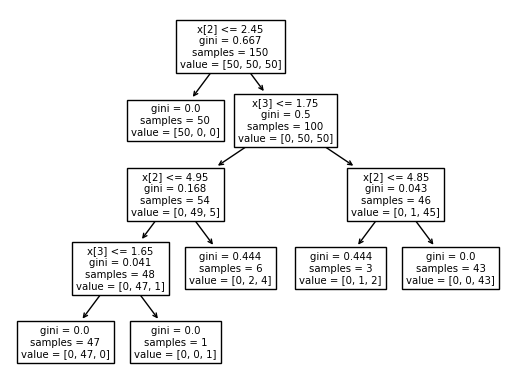

In [26]:
plot_tree(clf3)

Note, that sklearn's X[0] is equivalent to our X1. We can see the splits are the same (with a small rounding difference of 4.84 and 4.85).

The node splits alone are not sufficient to prove the models are equivalent since we have not recorded the order of splits i.e. which act on which branch, or the final prediction of each leaf node. For us that information is stored in the leaf nodes in the node_set_final. To predict results I will take an input and loop through the leaf nodes to check whether the observation would be in that leaf node, then make a prediction based on the modal class in that leaf node. The function below does this.

In [27]:
def predict(X, node_set_final):
    prediction = []
    for index, x in X.iterrows():
        for node in node_set_final:
            if (node["X3"].min() <= x["X3"] <= node["X3"].max()) and (node["X4"].min() <= x["X4"] <= node["X4"].max()):
                prediction.append(node["y"].mode()[0])
    return np.array(prediction)

I note, that this method does not account for any samples that land outside the ranges of the training observation or whether they land of the split boundary, however, it will do for now. Also note I have only included X3 and X4 as these are the only predictors that are used in this tree, a different tree would require some reformulation. Let's make predictions for our training data and compare to the sklearn model:

In [28]:
pred = predict(X=pd.DataFrame(pd.DataFrame(np.array([X1,X2,X3,X4,y]).transpose(), columns=["X1","X2","X3","X4","y"])), node_set_final=node_set_final)

In [29]:
sk_pred = clf3.predict(pd.DataFrame(pd.DataFrame(np.array([X1,X2,X3,X4]).transpose(), columns=["X1","X2","X3","X4"])))

In [30]:
sk_pred == pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Hence our models are functioning equally on the training dataset. However, the lack of transparency of how our tree works and how the branches are structured means we can't be sure that the models are exactly the same. This is something I have corrected in the next section where I look into pruning the tree.

To prune our decision tree to avoid overfitting we are going to use cost-complexity pruning (or weakest-link pruning). I have followed the process as described in this [article]( http://mlwiki.org/index.php/Cost-Complexity_Pruning ). This method uses the regularized loss function:
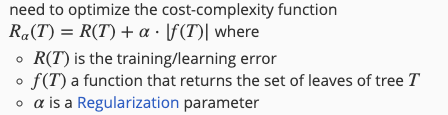
To do this we need build a large overfitted tree with very high purity (call this T0) and then calculate: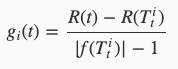
For each node in our full tree. 

When alpha = 0 (= alpha0), the tree that minimizes our loss function is the initial tree T0. Once we have calculated g(t) for all nodes in T0, we set alpha1 = min(g(t)) (= g(t1)). For alpha from alpha0 to alpha1 the tree that minimizes our loss function is the tree that corresponds T0 pruned at the node t1. Call this tree T1. We then repeat the process on T1 to find the next value of alpha and corresponding tree that minimizes the loss function for that alpha.

Let's perform this in steps. First we need to calculate the initial tree. Let's set the minimum samples as 2 so that we have a very low level of impurity. To aid future calculations I am going to add a few elements to our node_set_final and node_split outputs:

 - A 'route' element attached to each element in the node_set, making it a tuple, which takes the value of a 0 if it is a left split and 1 if it is a right split. This will result in a string of the form 01001 for a leaf node with a depth of 5 that has had 3 left splits and 2 right splits. This is also added to the node_split to identify the sequence of splits.
  - We add a split_id to the node_split to help identify the order of splits, as well as the node_set_final to identify the split that resulted in the leaf node.
  - We add the node training error which is the R(t) defined above in the formula, to the node_split output. The formula for this can be found in the link above
  
I have added comments where the algorithm has changed from above:

In [31]:
# Change the node_set items to be a tuple with the route and split id, also define these objects
route = ""
split_id = 0
node_set = [(pd.DataFrame(np.array([X1,X2,X3,X4,y]).transpose(), columns=["X1","X2","X3","X4","y"]), 
             route, split_id)]
node_split = []
node_set_final = []


while len(node_set) > 0:
    
    node_select = node_set[0]
    node_set.remove(node_select)
    
    # Add the [0] to select the data in the tuple
    training_node = node_select[0][["X1","X2","X3","X4"]]
    target_node = node_select[0]["y"]
    
    S = pd.DataFrame()
    for col in training_node.columns:
        S[col] = np.linspace(training_node[col].min(), training_node[col].max(), 100, endpoint=False)
        if training_node[col].min() ==  training_node[col].max():
            pass
        else:
            S["G"+col] = S[col].apply(G, args=(training_node[col], target_node))
        
    col_to_split = S.drop(["X1","X2","X3","X4"], axis=1).min().idxmin()
    s = round(S[S[col_to_split] == S[col_to_split].min()][col_to_split[-2:]].median(),2)
    
    if S.drop(["X1","X2","X3","X4"], axis=1).sum(axis=1).min() == 0:
        node_set_final.append(node_select)
    else:
        
        # If a split happends then add 1 to the split id
        split_id += 1
        node_set_left = node_select[0][node_select[0][col_to_split[-2:]] >= s]
        node_set_right = node_select[0][node_select[0][col_to_split[-2:]] < s]
        if len(node_set_left["X1"]) < 3:
            
            # Add a 0 to the route to signify it is a left branch (less than) and include the split id
            node_set_final.append((node_set_left, node_select[1] + "0", split_id))
        else:
            
            # Set the minimum samples split to 2
            node_set.append((node_set_left, node_select[1] + "0", split_id))
        if len(node_set_right["X1"]) < 3:
            
            # Add a 1 to the route to signify it is a right branch (greater than) and include the split id
            node_set_final.append((node_set_right, node_select[1] + "1", split_id))
        else:
            node_set.append((node_set_right, node_select[1] + "1", split_id))
        
        # Calculate the node training error
        node_training_error = sum(node_select[0]["y"] != node_select[0]["y"].mode()[0])/150
        
        # Add the split id, node training error and the route of the node set selected
        # Here the route shows where the split is being applied, i.e. the route of the node selected
        node_split.append((col_to_split[-2:], s, split_id, node_select[1], node_training_error))

In [32]:
node_split

[('X3', 2.45, 1, '', 0.6666666666666666),
 ('X4', 1.75, 2, '0', 0.3333333333333333),
 ('X3', 4.84, 3, '00', 0.006666666666666667),
 ('X3', 4.95, 4, '01', 0.03333333333333333),
 ('X1', 5.95, 5, '001', 0.006666666666666667),
 ('X4', 1.55, 6, '010', 0.013333333333333334),
 ('X4', 1.65, 7, '011', 0.006666666666666667),
 ('X1', 6.95, 8, '0100', 0.006666666666666667)]

Now we need to calculate the alpha for each inner node i.e. at each split in the node_split. We define a sub_leaves object that takes the subset of leaves of node t. We do this using the route of the splits and the leaf nodes. 

R(T) is the misclassification rate of that node, multiplied by the proportion of the total dataset that makes it to node t. I have made this a function since we will need to repeat it. It outputs the split_id, route, g(t) and the number of sub leaves for each node.

In [33]:
def alpha(node_set, node_split):
    alpha = []
    for split in node_split:
        sub_leaves = [node for node in node_set if split[3] == node[1][:len(split[3])]]
        R_t = split[4]
        R_T = sum([sum(leaf[0]["y"] != leaf[0]["y"].mode()[0]) / 150 for leaf in sub_leaves]) 
        g_t =( R_t - R_T ) / (len(sub_leaves) - 1)
        alpha.append((split[2], split[3], g_t, len(sub_leaves)))
    return alpha

The minimum alpha comes on split 3. Hence we need to prune the branch from split 3 and then re-run the alpha calculations.

In [34]:
alpha(node_set_final, node_split)

[(1, '', 0.08333333333333333, 9),
 (2, '0', 0.047619047619047616, 8),
 (3, '00', 0.0033333333333333335, 3),
 (4, '01', 0.008333333333333333, 5),
 (5, '001', 0.006666666666666667, 2),
 (6, '010', 0.006666666666666667, 3),
 (7, '011', 0.006666666666666667, 2),
 (8, '0100', 0.006666666666666667, 2)]

Set the node route at which to prune.

In [35]:
route = "00"

To perform the pruning I will create a new set of nodes with 00 in the route, i.e. the leaf nodes after split 3 and concatenate them. Then add in the other leaf nodes. We also need to adjust the node_split object to remove any nodes that have been pruned. Again this will be a repeatable process hence I will create a function.

In [36]:
def prune(node_set, node_split, route):    
    pruned_node = [node[0] for node in node_set if node[1][:len(route)] == route]
    pruned_node = [(pd.concat([node[0] for node in node_set if node[1][:len(route)] == route]), route, 3)]
    pruned_node += [node for node in node_set if node[1][:len(route)] != route]
    node_split_pruned = [split for split in node_split if split[3][:len(route)] != route]
    return pruned_node, node_split_pruned

We run the function to perform the pruning and produce a pruned node_set and pruned node_split.

In [37]:
pruned_node_1, split_pruned_1 = prune(node_set_final, node_split, route)

Then we can re-run the alpha calculations on our pruned tree:

In [38]:
alpha(pruned_node_1, split_pruned_1)

[(1, '', 0.10999999999999999, 7),
 (2, '0', 0.06533333333333333, 6),
 (4, '01', 0.008333333333333333, 5),
 (6, '010', 0.006666666666666667, 3),
 (7, '011', 0.006666666666666667, 2),
 (8, '0100', 0.006666666666666667, 2)]

In this instance we would again prune one of the nodes with the minimum g(t). In this case we have a number of minimum = 0.00667. According to the article when there a tie in minimum g(t) we take the node that will prune the fewest nodes. Since we have two nodes with equal g(t) and 2 dependent nodes I will chose to prune at split 8.

Let's set up a loop that prunes our tree recursively, and save each tree (leaf nodes and splits) and the corresponding alpha.

In [39]:
alpha_list = alpha(node_set_final, node_split)
alpha_list

[(1, '', 0.08333333333333333, 9),
 (2, '0', 0.047619047619047616, 8),
 (3, '00', 0.0033333333333333335, 3),
 (4, '01', 0.008333333333333333, 5),
 (5, '001', 0.006666666666666667, 2),
 (6, '010', 0.006666666666666667, 3),
 (7, '011', 0.006666666666666667, 2),
 (8, '0100', 0.006666666666666667, 2)]

In [40]:
tree_storage = [(node_set_final, node_split, 0)]
alpha_list = alpha(node_set_final, node_split)
node_to_be_pruned = node_set_final
split_to_be_pruned = node_split

while len(alpha_list) > 0:
    
    # Select the minimum g(t) and assign it to be alpha0, alpha1 etc..
    alpha_i = np.array([alph[2] for alph in alpha_list]).min()
    
    # Select the route with minimum g(t), there might be multiple hence select the last/deepest one
    route = [alph[1] for alph in alpha_list if alph[2] == alpha_i][-1]
    
    # Prune the tree, starting with the initial tree, and assign to be pruned again in the recursion
    node_to_be_pruned, split_to_be_pruned = prune(node_to_be_pruned, split_to_be_pruned, route)
    
    # Add the newly pruned tree and alpha value for that tree 
    tree_storage.append((node_to_be_pruned, split_to_be_pruned, alpha_i))
    
    # Calculate the g(t) for each node of the new pruned tree and repeat the process until there are no nodes left
    alpha_list = alpha(node_to_be_pruned, split_to_be_pruned)


We can view our sequence of alphas, and we know that the corresponding tree is saved within the tree storage object for when we need it later.

In [41]:
[i[2] for i in tree_storage]

[0,
 0.0033333333333333335,
 0.006666666666666667,
 0.006666666666666667,
 0.006666666666666667,
 0.013333333333333332,
 0.29333333333333333,
 0.3333333333333333]

We can interpret with sequence as such: at alpha = 0 the initial tree produced the minimal regularised loss. For alpha between 0 and 0.0033 the tree pruned once would give the minimal regularised loss, and so on. Several tree give the same value of alpha, implying they all minimise the loss equally.

To determine a the optimum value for alpha, we need to use K-fold cross validation. This would re-building the tree K times, on k folds of training data, pruning each one and getting an accuracy score for each subset tree. This would be possible but would be arduous in this format. As a result I am going to choose alpha on a simple training and validation split.

In [42]:
from sklearn.model_selection import train_test_split
X = pd.DataFrame(np.array([X1,X2,X3,X4]).transpose(), columns=["X1","X2","X3","X4"])
y.rename("y", inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Now we can re-run our tree build on just the training sample.

In [43]:
# Change the node_set items to be a tuple with the route and split id, also define these objects
route = ""
split_id = 0
node_set = [(pd.concat((X_train,y_train), axis=1), route, split_id)]
node_split = []
node_set_final = []


while len(node_set) > 0:
    
    node_select = node_set[0]
    node_set.remove(node_select)
    
    # Add the [0] to select the data in the tuple
    training_node = node_select[0][["X1","X2","X3","X4"]]
    target_node = node_select[0]["y"]
    
    S = pd.DataFrame()
    for col in training_node.columns:
        S[col] = np.linspace(training_node[col].min(), training_node[col].max(), 100, endpoint=False)
        if training_node[col].min() ==  training_node[col].max():
            pass
        else:
            S["G"+col] = S[col].apply(G, args=(training_node[col], target_node))
        
    col_to_split = S.drop(["X1","X2","X3","X4"], axis=1).min().idxmin()
    s = round(S[S[col_to_split] == S[col_to_split].min()][col_to_split[-2:]].median(),2)
    
    if S.drop(["X1","X2","X3","X4"], axis=1).sum(axis=1).min() == 0:
        node_set_final.append(node_select)
    else:
        
        # If a split happends then add 1 to the split id
        split_id += 1
        node_set_left = node_select[0][node_select[0][col_to_split[-2:]] >= s]
        node_set_right = node_select[0][node_select[0][col_to_split[-2:]] < s]
        if len(node_set_left["X1"]) < 3:
            
            # Add a 0 to the route to signify it is a left branch (less than) and include the split id
            node_set_final.append((node_set_left, node_select[1] + "0", split_id))
        else:
            node_set.append((node_set_left, node_select[1] + "0", split_id))
        if len(node_set_right["X1"]) < 3:
            
            # Add a 1 to the route to signify it is a right branch (greater than) and include the split id
            node_set_final.append((node_set_right, node_select[1] + "1", split_id))
        else:
            node_set.append((node_set_right, node_select[1] + "1", split_id))
        
        # Calculate the node training error
        node_training_error = sum(node_select[0]["y"] != node_select[0]["y"].mode()[0])/150
        
        # Add the split id, node training error and the route of the node set selected
        # Here the route shows where the split is being applied, i.e. the route of the node selected
        node_split.append((col_to_split[-2:], s, split_id, node_select[1], node_training_error))

Let's have a look at our new tree. We can see that are are fewer nodes, which is to be expected with a smaller dataset. This is one reason why cross validation is more appropriate when deriving alpha for real.

In [44]:
node_split

[('X3', 2.59, 1, '', 0.4533333333333333),
 ('X4', 1.65, 2, '0', 0.21333333333333335),
 ('X3', 4.85, 3, '00', 0.006666666666666667),
 ('X3', 4.99, 4, '01', 0.02),
 ('X2', 3.1, 5, '001', 0.006666666666666667),
 ('X1', 6.05, 6, '010', 0.006666666666666667)]

On our new tree we can re-run the pruning process calculating the alpha for each pruned tree and storing them in a tree_storage_train object.

In [45]:
tree_storage_train = [(node_set_final, node_split, 0)]
alpha_list = alpha(node_set_final, node_split)
node_to_be_pruned = node_set_final
split_to_be_pruned = node_split

while len(alpha_list) > 0:
    
    # Select the minimum g(t) and assign it to be alpha0, alpha1 etc..
    alpha_i = np.array([alph[2] for alph in alpha_list]).min()
    
    # Select the route with minimum g(t), there might be multiple hence select the last/deepest one
    route = [alph[1] for alph in alpha_list if alph[2] == alpha_i][-1]
    
    # Prune the tree, starting with the initial tree, and assign to be pruned again in the recursion
    node_to_be_pruned, split_to_be_pruned = prune(node_to_be_pruned, split_to_be_pruned, route)
    
    # Add the newly pruned tree and alpha value for that tree 
    tree_storage_train.append((node_to_be_pruned, split_to_be_pruned, alpha_i))
    
    # Calculate the g(t) for each node of the new pruned tree and repeat the process until there are no nodes left
    alpha_list = alpha(node_to_be_pruned, split_to_be_pruned)


Let's look at the sequence of alphas on the tree built on our training set. We can see between the 

In [46]:
[i[2] for i in tree_storage_train]

[0,
 0.0033333333333333335,
 0.006666666666666667,
 0.013333333333333332,
 0.18666666666666668,
 0.23999999999999996]

To determine our optimum value of alpha we need to make predictions using each tree and score their accuracy. Then we will have an accuracy score for each alpha, from which we pick alpha with the highest accuracy.

Our previous prediction method is now no longer viable, since it required the predictors to be within the bounds of the training dataset, since we have split this up we may have test observations that do not lie within the bounds of our leaf nodes. As a result I have re-written the predict function to chose a leaf node based on the route. This is a much more robust way of predicting and follows the logic of a decision tree much more closely, and on reflection I should have included it initially. However, as a I stated in the introduction I wanted this article to show my progression in building this model and the learnings I had along the way.

In [47]:
def predict(X, node_set, node_split):
    predict = []
    for index, x in X.iterrows():
        route = ""
        for split in node_split:
            if route == split[3]:
                if x[split[0]] >= split[1]:
                    route += "0"
                else:
                    route += "1"

        predict.append([node for node in node_set if node[1] == route][0][0]["y"].mode()[0])
    return predict
    

Now we make a prediction for each tree we created during our pruning process. I have shown below each alpha and the corresponding prediction accuracy.

In [48]:
alpha_pred_error = []
for tree in tree_storage_train:
    
    pred = predict(X_test, node_set=tree[0], node_split=tree[1])
    accuracy = sum(y_test == pred) / len(pred)
    alpha_pred_error.append((tree[2],accuracy))
    
alpha_pred_error

[(0, 0.9555555555555556),
 (0.0033333333333333335, 0.9555555555555556),
 (0.006666666666666667, 0.9777777777777777),
 (0.013333333333333332, 0.9555555555555556),
 (0.18666666666666668, 0.6),
 (0.23999999999999996, 0.28888888888888886)]

Prediction accuracy is highes at alpha = 0.00667. We had multiple trees at this value of alpha. Let's take a quick look at these:

In [49]:
[i[1] for i in tree_storage if 0.0066 < i[2] < 0.0067]

[[('X3', 2.45, 1, '', 0.6666666666666666),
  ('X4', 1.75, 2, '0', 0.3333333333333333),
  ('X3', 4.95, 4, '01', 0.03333333333333333),
  ('X4', 1.55, 6, '010', 0.013333333333333334),
  ('X4', 1.65, 7, '011', 0.006666666666666667)],
 [('X3', 2.45, 1, '', 0.6666666666666666),
  ('X4', 1.75, 2, '0', 0.3333333333333333),
  ('X3', 4.95, 4, '01', 0.03333333333333333),
  ('X4', 1.55, 6, '010', 0.013333333333333334)],
 [('X3', 2.45, 1, '', 0.6666666666666666),
  ('X4', 1.75, 2, '0', 0.3333333333333333),
  ('X3', 4.95, 4, '01', 0.03333333333333333)]]

We have three trees, with 3, 4 and 5 inner nodes respectively. Each have the same regularised loss and hence under this method we would be justified in picking any one. We would just be trading off the risk of over-fitting with accuracy.

Realistically, we would need to perform cross validation to get a less uncertain prediction for alpha. I have played around with the random state of our train, validation split and our prediction for alpha has a high variance. This is likely due to the size of the dataset too. Overall we have still managed to follow the process of building and pruning a decision tree from scratch, it was a long process but we got there!

I think this had been the most interesting and rewarding 'build your own' ML model I hav done so far. It has certianly been the most challenging. Please let me know any feedback you have using the contact sheet below!